# DNN 정형데이터 템플릿 - 다중클래스 분류(K-class) 완전체
시험장에서 **컬럼명만 바꾸고 복붙**해서 바로 돌릴 수 있게 만든 3교시용 템플릿입니다.

## 🎯 공통 평가 포인트(출제 의도)
- 데이터 탐색(결측/분포/불균형) → 전처리(범주/수치) → DNN 학습 → 지표 평가 → (분류면) 운영 정책/리포트
- 과적합 방지(드롭아웃/weight decay/validation)
- (가산) 간단 해석(오차 상위 샘플/Confusion matrix/정책 기반 리포트)

## ✅ 시험장에서 바꾸는 곳(필수 3개)
- `CSV_PATH` (토이데이터 대신 실제 CSV)
- `target_col`
- `cat_cols` (범주형 리스트)
나머지는 거의 그대로 사용 가능.


## 0) Imports & 재현성

In [1]:
import os, random, warnings, math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler, RobustScaler
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline

warnings.filterwarnings("ignore")

SEED = 42
random.seed(SEED)
np.random.seed(SEED)

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device


device(type='cpu')

## 1) 토이데이터 생성 (다중클래스 분류)
예시 컨셉: 불량 유형 분류 `defect_type` (0=정상, 1=스크래치, 2=오염, 3=찍힘)

- 클래스 불균형(정상 많음, 특정 불량 희귀)
- 포함 요소: 결측 + 일부 클래스별 특성 패턴


In [2]:
def make_toy_multiclass(n=30000, seed=42):
    rng = np.random.default_rng(seed)

    line_id = rng.integers(1, 7, size=n).astype(str)
    shift = rng.choice(["day","swing","night"], size=n, p=[0.5,0.3,0.2])
    supplier = rng.choice(["A","B","C","D","E"], size=n, p=[0.25,0.25,0.2,0.2,0.1])
    material_grade = rng.choice(["G1","G2","G3"], size=n, p=[0.55,0.35,0.10])

    temp = rng.normal(70, 5, size=n) + (line_id.astype(int)-3)*0.7
    pressure = np.abs(rng.normal(1.1, 0.35, size=n))
    vibration = np.abs(rng.normal(3.0, 1.0, size=n)) + (shift=="night")*0.6
    humidity = np.clip(rng.normal(45, 10, size=n), 10, 90)
    cycle_time = rng.normal(120, 15, size=n) + (material_grade=="G3")*7
    error_cnt = rng.poisson(1.3, size=n) + (supplier=="E")*1

    score1 = 0.9*np.maximum(0, vibration-3.7) + 0.4*(shift=="night") + rng.normal(0,0.3,n)
    score2 = 0.08*np.maximum(0, humidity-55) + 0.5*(supplier=="E") + rng.normal(0,0.2,n)
    score3 = 0.03*np.maximum(0, cycle_time-135) + 0.7*np.maximum(0, pressure-1.4) + rng.normal(0,0.25,n)

    y = np.zeros(n, dtype=int)
    y[score1 >= np.quantile(score1, 0.97)] = 1
    y[(y==0) & (score2 >= np.quantile(score2, 0.985))] = 2
    y[(y==0) & (score3 >= np.quantile(score3, 0.99))] = 3

    df = pd.DataFrame({
        "line_id": line_id,
        "shift": shift,
        "supplier": supplier,
        "material_grade": material_grade,
        "temp": temp,
        "pressure": pressure,
        "vibration": vibration,
        "humidity": humidity,
        "cycle_time": cycle_time,
        "error_cnt": error_cnt,
        "defect_type": y
    })

    for col in ["temp","pressure","humidity"]:
        m = rng.random(n) < 0.02
        df.loc[m, col] = np.nan

    o = rng.random(n) < 0.004
    df.loc[o, "vibration"] *= 4
    df.loc[o, "error_cnt"] += 10
    return df

df = make_toy_multiclass()
df.head()


,line_id,shift,supplier,material_grade,temp,pressure,vibration,humidity,cycle_time,error_cnt,defect_type
0,1,day,C,G3,63.713757,0.886629,3.508741,46.856441,106.234381,1,0
1,5,day,D,G1,69.246388,1.395863,3.638626,48.787376,136.128378,0,0
2,4,day,B,G3,72.795986,1.914635,3.648248,46.910886,121.451003,1,0
3,3,night,A,G2,68.855717,0.571317,3.914765,31.483373,145.967493,1,0
4,3,day,A,G2,67.603604,1.374678,3.938268,27.971584,132.846780,2,0


## 2) 데이터 탐색(EDA): 크기/결측/타깃 분포

Shape: (30000, 11)

Target counts:
defect_type
0    28378
1      900
2      437
3      285
Name: count, dtype: int64

Target ratio:
defect_type
0    0.945933
1    0.030000
2    0.014567
3    0.009500
Name: proportion, dtype: float64

Missing ratio top:
pressure          0.021000
temp              0.020000
humidity          0.019333
supplier          0.000000
shift             0.000000
line_id           0.000000
material_grade    0.000000
vibration         0.000000
cycle_time        0.000000
error_cnt         0.000000
dtype: float64


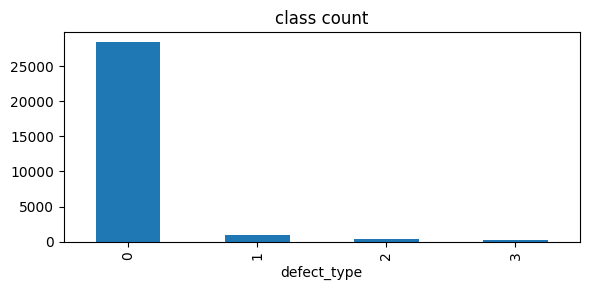

In [3]:
target_col = "defect_type"
cat_cols = ["line_id","shift","supplier","material_grade"]
num_cols = [c for c in df.columns if c not in cat_cols + [target_col]]

print("Shape:", df.shape)
print("\nTarget counts:")
print(df[target_col].value_counts().sort_index())
print("\nTarget ratio:")
print(df[target_col].value_counts(normalize=True).sort_index())

print("\nMissing ratio top:")
print(df.isna().mean().sort_values(ascending=False).head(10))

plt.figure(figsize=(6,3))
df[target_col].value_counts().sort_index().plot(kind="bar", title="class count")
plt.tight_layout()
plt.show()


## 3) Split & 전처리(범주형/수치형)

In [4]:
X = df[cat_cols + num_cols].copy()
y = df[target_col].copy()
X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=0.2, random_state=SEED, stratify=y
)

USE_ROBUST = True
scaler = RobustScaler() if USE_ROBUST else StandardScaler()

cat_pipe = Pipeline([
    ("imp", SimpleImputer(strategy="most_frequent")),
    ("ohe", OneHotEncoder(handle_unknown="ignore"))
])
num_pipe = Pipeline([
    ("imp", SimpleImputer(strategy="median")),
    ("sc", scaler)
])
preprocess = ColumnTransformer([
    ("cat", cat_pipe, cat_cols),
    ("num", num_pipe, num_cols),
])

X_train_enc = preprocess.fit_transform(X_train)
X_val_enc = preprocess.transform(X_val)

X_train_dense = X_train_enc.toarray() if hasattr(X_train_enc, "toarray") else np.asarray(X_train_enc)
X_val_dense = X_val_enc.toarray() if hasattr(X_val_enc, "toarray") else np.asarray(X_val_enc)

print("Dense shapes:", X_train_dense.shape, X_val_dense.shape)


Dense shapes: (24000, 23) (6000, 23)


## 4) PyTorch Dataset/DataLoader

In [5]:
class TabularDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.tensor(X, dtype=torch.float32)
        self.y = torch.tensor(y.values, dtype=torch.long)  # class index [0..K-1]
    def __len__(self): return len(self.X)
    def __getitem__(self, idx): return self.X[idx], self.y[idx]

train_ds = TabularDataset(X_train_dense, y_train.astype(int))
val_ds = TabularDataset(X_val_dense, y_val.astype(int))

train_loader = DataLoader(train_ds, batch_size=256, shuffle=True)
val_loader = DataLoader(val_ds, batch_size=512, shuffle=False)


## 5) DNN 모델 + 손실/가중치(불균형 대응)

In [6]:
in_dim = X_train_dense.shape[1]
K = int(y_train.max()) + 1
out_dim = K

class DNN(nn.Module):
    def __init__(self, in_dim, out_dim):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(in_dim, 128),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(64, out_dim),
        )
    def forward(self, x):
        return self.net(x)

model = DNN(in_dim, out_dim).to(device)

counts = y_train.value_counts().sort_index()
K = int(counts.index.max()) + 1
weights = np.zeros(K, dtype=np.float32)
total = len(y_train)
for c in range(K):
    nc = int(counts.get(c, 1))
    weights[c] = total / (K * nc)
class_weights = torch.tensor(weights, dtype=torch.float32, device=device)

criterion = nn.CrossEntropyLoss(weight=class_weights)
print("class_weights:", class_weights.cpu().numpy())

optimizer = torch.optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-4)


class_weights: [ 0.2642939  8.333333  17.142857  26.31579  ]


## 6) 학습/평가 루프

In [7]:
from sklearn.metrics import f1_score, accuracy_score, confusion_matrix, classification_report

def eval_val():
    model.eval()
    val_loss = 0.0
    n = 0
    logits_all = []
    y_all = []
    with torch.no_grad():
        for xb, yb in val_loader:
            xb = xb.to(device); yb = yb.to(device)
            logits = model(xb)
            loss = criterion(logits, yb)
            val_loss += loss.item() * len(xb)
            n += len(xb)
            logits_all.append(logits.cpu().numpy())
            y_all.append(yb.cpu().numpy())
    logits_all = np.vstack(logits_all)
    y_all = np.concatenate(y_all)
    y_pred = logits_all.argmax(axis=1)
    macro_f1 = f1_score(y_all, y_pred, average="macro")
    acc = accuracy_score(y_all, y_pred)
    return val_loss / n, y_all, y_pred, macro_f1, acc

best_f1 = -1
best_state = None
EPOCHS = 20

for epoch in range(1, EPOCHS+1):
    model.train()
    tr_loss = 0.0
    n = 0
    for xb, yb in train_loader:
        xb = xb.to(device); yb = yb.to(device)
        optimizer.zero_grad()
        logits = model(xb)
        loss = criterion(logits, yb)
        loss.backward()
        optimizer.step()
        tr_loss += loss.item() * len(xb)
        n += len(xb)

    val_loss, y_true, y_pred, macro_f1, acc = eval_val()
    if macro_f1 > best_f1:
        best_f1 = macro_f1
        best_state = {k:v.cpu().clone() for k,v in model.state_dict().items()}

    if epoch % 5 == 0 or epoch == 1:
        print(f"epoch {epoch:02d} | train_loss {tr_loss/n:.4f} | val_loss {val_loss:.4f} | macroF1 {macro_f1:.4f} | acc {acc:.4f}")

model.load_state_dict(best_state)
print("Best macro F1:", best_f1)


epoch 01 | train_loss 0.9736 | val_loss 0.5345 | macroF1 0.3436 | acc 0.5875
epoch 05 | train_loss 0.3721 | val_loss 0.3648 | macroF1 0.4500 | acc 0.7895
epoch 10 | train_loss 0.3238 | val_loss 0.3264 | macroF1 0.4760 | acc 0.8167
epoch 15 | train_loss 0.2821 | val_loss 0.3198 | macroF1 0.5152 | acc 0.8420
epoch 20 | train_loss 0.2770 | val_loss 0.3192 | macroF1 0.5159 | acc 0.8417
Best macro F1: 0.5256639234058277


## 7) 다중클래스 출력(필수): macroF1 + confusion matrix + 리포트

In [8]:
from sklearn.metrics import f1_score, confusion_matrix, classification_report

# 예측
model.eval()
with torch.no_grad():
    logits = model(torch.tensor(X_val_dense, dtype=torch.float32, device=device)).cpu().numpy()
y_true = y_val.values.astype(int)
y_pred = logits.argmax(axis=1)

macro_f1 = f1_score(y_true, y_pred, average="macro")
print("macro F1:", macro_f1)
print("\nClassification report:")
print(classification_report(y_true, y_pred, digits=4))

cm = confusion_matrix(y_true, y_pred)
print("\nConfusion matrix:\n", cm)

# 확신도 높은 샘플(상위 30)
probs = np.exp(logits - logits.max(axis=1, keepdims=True))
probs = probs / probs.sum(axis=1, keepdims=True)
conf = probs.max(axis=1)

val_report = X_val.copy()
val_report["y_true"] = y_true
val_report["y_pred"] = y_pred
val_report["confidence"] = conf
val_report.sort_values("confidence", ascending=False).head(30)


macro F1: 0.5256639234058277

Classification report:
              precision    recall  f1-score   support

           0     0.9957    0.8510    0.9176      5676
           1     0.4085    0.9056    0.5630       180
           2     0.2781    0.9655    0.4319        87
           3     0.1071    0.8421    0.1901        57

    accuracy                         0.8542      6000
   macro avg     0.4474    0.8910    0.5257      6000
weighted avg     0.9592    0.8542    0.8930      6000


Confusion matrix:
 [[4830  235  213  398]
 [  10  163    5    2]
 [   3    0   84    0]
 [   8    1    0   48]]


,line_id,shift,supplier,material_grade,temp,pressure,vibration,humidity,cycle_time,error_cnt,y_true,y_pred,confidence
12986,4,swing,A,G2,75.062935,2.008633,2.889098,85.896136,114.992015,1,2,2,0.999999
7593,4,swing,A,G1,74.052184,1.315420,2.915322,82.841283,134.173509,2,2,2,0.999995
1085,6,swing,C,G2,71.839047,1.762600,23.764539,50.657548,104.426872,11,1,1,0.999981
9204,4,day,E,G2,77.477910,0.719405,4.157446,73.765919,126.671020,2,2,2,0.999976
20399,5,day,A,G3,69.091720,1.297632,3.381555,76.991838,133.789936,0,2,2,0.999942
23107,1,swing,E,G1,69.397096,1.936052,3.612775,72.355236,87.593897,2,2,2,0.999926
28936,4,swing,C,G2,78.017041,0.896129,2.743177,74.402622,133.530888,0,2,2,0.999902
2178,4,night,C,G2,71.482891,1.322488,2.115495,74.934246,129.207994,3,2,2,0.999901
26114,2,swing,C,G2,70.284310,1.044806,4.443556,80.308181,122.209506,4,2,2,0.999901
3009,5,day,A,G2,69.935155,1.060095,2.764994,75.317452,112.583035,2,2,2,0.999896


## 8) 시험장 복붙 체크리스트(초압축)
1) `CSV_PATH` 로딩 → `target_col`, `cat_cols` 지정  
2) `num_cols` 자동 생성 확인  
3) 전처리(OHE+Scaler) → dense 변환  
4) DNN 학습(Adam + dropout + weight_decay)  
5) 회귀: MAE/RMSE / 이진: PR-AUC+임계값 / 다중: macroF1+confusion  
6) 리포트 출력(TopN/오차상위/확신상위)까지 하면 점수 잘 나옴
